# Part 2: Time Series Modeling

In this notebook, you will implement functions to extract features from time series data and build ARIMA models.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pathlib import Path
import os

# Set style for plots
%matplotlib inline

## 1. Feature Extraction

Implement the `extract_time_series_features` function to calculate rolling window features.

In [2]:
# load processed data
df = pd.DataFrame()
subjects = pd.Series(range(10))+1
subjects = 'S' + subjects.astype('str')
for subject in subjects:
    current = pd.read_csv('data/processed/' + subject + '_processed.csv')
    if df.empty == True:
        df = current
    else:
        df = pd.concat([df, current], axis=0)
df = df.iloc[:, 1:] # drop non-data index column

def extract_time_series_features(data, window_size=60):
    """Extract rolling window features from time series data.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    window_size : int
        Size of the rolling window in seconds
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing extracted features for each signal
    """
    # Your code here
    # 1. Calculate rolling window statistics
    # 2. Include mean, std, min, max, and autocorrelation

    df = data.set_index('timestamp')
    df = df[['eda', 'heart_rate', 'temperature']]
    rolling_mean = df.rolling(window=window_size).mean().dropna()
    rolling_sd = df.rolling(window=window_size).std().dropna()
    min_df = df.min()
    max_df = df.max()
    return rolling_mean, rolling_sd, min_df, max_df

# extracting features from Final data for S1
s1_final = df[(df['subject_id']=='S1') & (df['session']=='Final')]
roll_mean_df, roll_sd_df, min_df, max_df = extract_time_series_features(s1_final)
min_df

eda             0.011532
heart_rate     62.280000
temperature    17.190000
dtype: float64

In [3]:
roll_mean_df

,eda,heart_rate,temperature
timestamp,,,
2018-12-05 16:30:06,0.023534,120.990333,22.202000
2018-12-05 16:30:07,0.023512,121.242333,22.206333
2018-12-05 16:30:08,0.023534,122.072667,22.210333
2018-12-05 16:30:09,0.023512,122.670833,22.214000
2018-12-05 16:30:10,0.023491,123.453667,22.218000
...,...,...,...
2018-12-05 22:58:48,0.026203,130.910333,24.857333
2018-12-05 22:58:49,0.026203,130.779833,24.897333
2018-12-05 22:58:50,0.026225,130.636167,24.937000


## 2. ARIMA Modeling

Implement the `build_arima_model` function to fit ARIMA models and generate diagnostic plots.

In [4]:
def build_arima_model(series, order=(1,1,1), output_dir='plots'):
    """Fit an ARIMA model to the time series and generate diagnostic plots.
    
    Parameters
    ----------
    series : pd.Series
        Time series data to model
    order : tuple
        (p,d,q) order of the ARIMA model
    output_dir : str
        Directory to save diagnostic plots
        
    Returns
    -------
    statsmodels.tsa.arima.model.ARIMAResults
        Fitted ARIMA model
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Fit ARIMA model
    print('Fitting model...') # debug print
    model = ARIMA(series, order=order)
    results = model.fit()

    # 2. Generate diagnostic plots:
    #    - Model fit plot
    print('Plotting model fit...') # debug print
    plt.figure(figsize=(10,6))
    plt.plot(results.fittedvalues, label='Fitted Values')
    plt.title('Fitted values plot')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'model_fit_plot.png')) # 3. Save plots to output directory
    plt.close

    #    - Residuals plot
    print('Plotting residuals...') # debug print
    residuals = results.resid # get residual data
    plt.figure(figsize=(10,6))
    plt.plot(residuals, label='Residuals')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'residuals_plot.png')) # 3. Save plots to output directory
    plt.close()

    #    - Forecast plot
    print('Plotting forecast...') # debug print
    forecast = results.get_forecast(steps=50)
    plt.figure(figsize=(10, 6))
    plt.plot(series, linestyle='-') # plot actual data
    forecast_index = pd.date_range(start=series.index[-1], periods=51, freq=series.index.inferred_freq)[1:] # infer frequency based on the freq of the inputted series
    plt.plot(forecast_index, forecast.predicted_mean, linestyle='--') # plot the predictions past actual data using dashed line
    plt.title('Forecast plot')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'forecast_plot.png')) # 3. Save plots to output directory
    plt.close()

    print('Done')

    return results

Fitting model...


/home/hcheng25/4-it-s-about-time-hcheng25/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency s will be used.
  self._init_dates(dates, freq)
/home/hcheng25/4-it-s-about-time-hcheng25/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency s will be used.
  self._init_dates(dates, freq)
/home/hcheng25/4-it-s-about-time-hcheng25/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency s will be used.
  self._init_dates(dates, freq)
/home/hcheng25/4-it-s-about-time-hcheng25/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting model fit...
Plotting residuals...
Plotting forecast...
Done


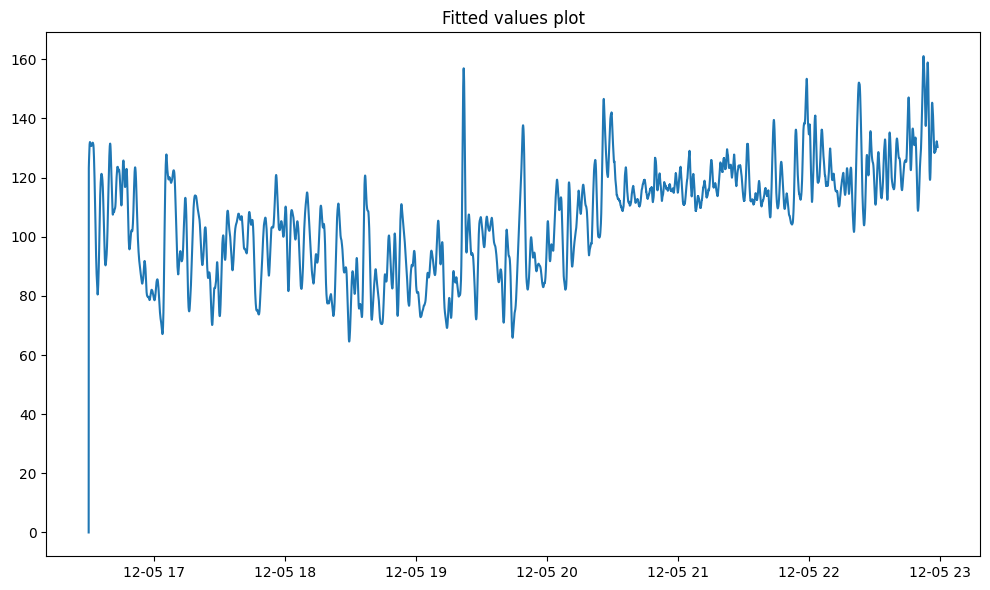

In [5]:
roll_mean_df.index = pd.to_datetime(roll_mean_df.index) # ensure timestamp index is datetime
build_arima_model(series=roll_mean_df['heart_rate'], order=(1,1,1), output_dir='plots/s1_final')